# Importing data

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('../input/train.csv', header=0, sep=',', quotechar='"', usecols=['target', 'comment_text'])
train['target_bool'] = np.where(train['target']>=0.5, 1, 0)
train[train['target_bool'] ==1].describe()

,target,target_bool
count,144334.000000,144334.0
mean,0.656787,1.0
std,0.139473,0.0
min,0.500000,1.0
25%,0.500000,1.0
50%,0.603175,1.0
75%,0.761905,1.0
max,1.000000,1.0


# Exploirng data

### small set of everything : train_explore

In [3]:
#select a subset of the train dataset accodirng to the portion (between 0 and 1)
portion = 1
indices = np.random.permutation(train.shape[0])
explore_idx = indices[:np.int(portion * train.shape[0])]
train_explore = train.iloc[explore_idx]
print("New shape is : " + str(train_explore.shape))

New shape is : (1804874, 3)


# Playing with TF.IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import datetime
import string

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


## For the unclean train_explore

### first we need to clean !

#### 1)In this version, stopwords are removed using tokeninsation and then search in list. Seems to be very inefficient (time consumming)**

In [5]:
# train_explore_clean = train_explore
# lemmatizer = nltk.WordNetLemmatizer()
# stop = stopwords.words("english")
# tokenizer = nltk.TreebankWordTokenizer()

# #cleaning
# tic = datetime.datetime.now()
# train_explore_clean['comment_text_clean'] = train_explore_clean['comment_text'].str.replace('[0-9]','') ### remove numbers
# tac = datetime.datetime.now()
# time = tac - tic
# print("remove number time" + str(time))
# tic = datetime.datetime.now()
# train_explore_clean['comment_text_clean']=train_explore_clean['comment_text_clean'].apply(lambda x : x.lower()) ### to lower case
# tac = datetime.datetime.now()
# time = tac - tic
# print("To lower time" + str(time))
# tic = datetime.datetime.now()
# train_explore_clean['comment_text_token'] = train_explore_clean['comment_text_clean'].apply(lambda x : tokenizer.tokenize(x)) ### tokenize
# tac = datetime.datetime.now()
# time = tac - tic
# print("Tokenize time" + str(time))
# tic = datetime.datetime.now()
# train_explore_clean['comment_text_token_no_stop'] = train_explore_clean['comment_text_token'].apply(lambda x: [item for item in x if item not in stop]) ### remove stopr words
# tac = datetime.datetime.now()
# time = tac - tic
# print("Remove stopword time" + str(time))
# tic = datetime.datetime.now()
# train_explore_clean['comment_text_token_no_stop'] = train_explore_clean['comment_text_token_no_stop'].apply(lambda x : " ".join(x))
# tac = datetime.datetime.now()
# time = tac - tic
# print("Join time" + str(time))



# train_explore_clean.head()

#### 2)Different process for removing stop words wichi is Three to four time faster (most likely because it does not tokenize and save in a new column)****

In [6]:
train_explore_clean = train_explore
lemmatizer = nltk.WordNetLemmatizer()
stops = stopwords.words("english")
tokenizer = nltk.TreebankWordTokenizer()

def remove_words_in_string(sentence, words):
    sentence = sentence
    remove_list = words
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    sentence = sentence.translate(translator)
    word_list = sentence.split()
    return ' '.join([i for i in word_list if i not in remove_list])

# cleaning
# 
tic = datetime.datetime.now()
train_explore_clean['comment_text_clean'] = train_explore_clean['comment_text'].str.replace('[0-9]','') ### remove numbers
tac = datetime.datetime.now()
time = tac - tic
print("remove number time" + str(time))
tic = datetime.datetime.now()
train_explore_clean['comment_text_clean']=train_explore_clean['comment_text_clean'].apply(lambda x : x.lower()) ### to lower case
tac = datetime.datetime.now()
time = tac - tic
print("To lower time" + str(time))
tic = datetime.datetime.now()
train_explore_clean['comment_no_stop']=train_explore_clean['comment_text_clean'].apply(lambda sentence : remove_words_in_string(sentence, stops)) ### to lower case
tac = datetime.datetime.now()
time = tac - tic
print("remove stop words time : " + str(time))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


remove number time0:00:08.151427


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To lower time0:00:02.640174
remove stop words time : 0:02:52.306908


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## TFIDF on the toxic part only !!

### Load packages

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import average_precision_score, roc_curve, roc_auc_score, classification_report
from matplotlib import pyplot
from sklearn.naive_bayes import MultinomialNB

### TFIDF (set with a threshold of toxicity)

In [8]:
#parameters
max_df = 0.3
min_df = 0.003 
toxicity_threshold = 0.2
n_gram = (1, 3)

#processing
texts = train_explore_clean[train_explore_clean['target'] >toxicity_threshold ]['comment_no_stop']
tfidf = TfidfVectorizer(min_df=np.int(min_df * texts.shape[0]), max_df=max_df, ngram_range=n_gram)
features = tfidf.fit_transform(texts)
vectorizer = pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names()
)
print( "column names are " + str(vectorizer.columns.values), " Number of column is " + str (vectorizer.columns.shape))

column names are ['ability' 'able' 'abortion' ... 'yet' 'young' 'zero']  Number of column is (1583,)


# Experimenting models

## Splitting train/dev set

In [9]:
# df = pd.DataFrame(train_explore_clean[train_explore_clean['comment_text_token_no_stop'].str.contains(u'could care less')][['target','comment_text']])
X = tfidf.transform(train_explore_clean['comment_no_stop'])
y=  train_explore_clean['target_bool']
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.05, random_state =42)

## Logistic regression

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.900


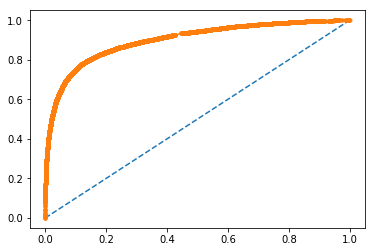

'              precision    recall  f1-score   support\n\n           0       0.95      0.99      0.97     83060\n           1       0.76      0.42      0.54      7184\n\n   micro avg       0.94      0.94      0.94     90244\n   macro avg       0.85      0.70      0.75     90244\nweighted avg       0.94      0.94      0.94     90244\n'

In [10]:
logisticRegr = LogisticRegression(C=2)
logisticRegr.fit(xTrain, yTrain)
predictions = logisticRegr.predict_proba(xTest)
predictions = pd.DataFrame(predictions)
# cm = metrics.confusion_matrix(yTest, predictions)
# print(cm)
# average_precision = average_precision_score(yTest, predictions)
# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))
fpr, tpr, thresholds = roc_curve(yTest, predictions[1])
auc = roc_auc_score(yTest, predictions[1])
print('AUC: %.3f' % auc)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
classification_report(yTest, predictions[1]>0.5)

## Naives bayes

AUC: 0.862


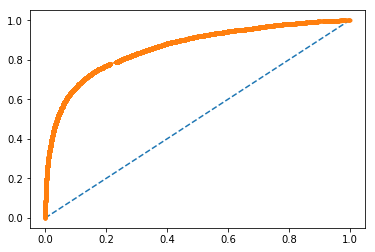

'              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96     83060\n           1       0.93      0.06      0.11      7184\n\n   micro avg       0.92      0.92      0.92     90244\n   macro avg       0.93      0.53      0.54     90244\nweighted avg       0.92      0.92      0.89     90244\n'

In [11]:
Naive = MultinomialNB()
Naive.fit(xTrain,yTrain)

#Predict the response for test dataset
predictions = Naive.predict_proba(xTest)
predictions = pd.DataFrame(predictions)


# cm = metrics.confusion_matrix(yTest, predictions)
# print(cm)
# average_precision = average_precision_score(yTest, predictions)
# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))
fpr, tpr, thresholds = roc_curve(yTest, predictions[1])
auc = roc_auc_score(yTest, predictions[1])
print('AUC: %.3f' % auc)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
classification_report(yTest, predictions[1]>0.5)

# Submission

### Cleaning test set

In [12]:
test = pd.read_csv('../input/test.csv', header=0, sep=',', quotechar='"')
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words("english")
tokenizer = nltk.TreebankWordTokenizer()

#cleaning
tic = datetime.datetime.now()
test['comment_text_clean'] = test['comment_text'].str.replace('[0-9]','') ### remove numbers
tac = datetime.datetime.now()
time = tac - tic
print("remove number time" + str(time))
tic = datetime.datetime.now()
test['comment_text_clean']=test['comment_text_clean'].apply(lambda x : x.lower()) ### to lower case
tac = datetime.datetime.now()
time = tac - tic
print("To lower time" + str(time))
tic = datetime.datetime.now()
test['comment_no_stop']=test['comment_text_clean'].apply(lambda sentence : remove_words_in_string(sentence, stops)) ### to lower case
tac = datetime.datetime.now()
time = tac - tic
print("remove stop words time : " + str(time))


remove number time0:00:00.354396
To lower time0:00:00.089528
remove stop words time : 0:00:09.343736


### Submission

In [13]:
test = tfidf.transform(test['comment_no_stop'])
submission =  logisticRegr.predict_proba(test)
submission = pd.DataFrame(submission)
my_submission = pd.read_csv('../input/sample_submission.csv', header=0, sep=',', quotechar='"')
my_submission = pd.merge(submission, my_submission, left_index=True, right_index=True)
my_submission=my_submission[['id', 1]].rename(columns= {1 : 'prediction'})
my_submission.to_csv(r'submission.csv', index=False)


In [14]:
my_submission.head(10)

,id,prediction
0,7000000,0.053069
1,7000001,0.018870
2,7000002,0.031705
3,7000003,0.013628
4,7000004,0.977607
5,7000005,0.010354
6,7000006,0.022338
7,7000007,0.026845
8,7000008,0.007408
9,7000009,0.020587
